# QSVM for AdHoc Dataset
## Prepare data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit import Aer
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler
from qiskit.providers.ibmq import least_busy
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel, FidelityQuantumKernel
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.svm import SVC

In [2]:
df = pd.read_csv('datasets/adhoc_100.csv', index_col=0)
df

,feature_1,feature_2,label
0,2.953097,2.324779,0.0
1,1.382301,4.021239,0.0
2,5.592035,5.152212,0.0
3,4.084070,1.130973,0.0
4,5.906194,2.827433,0.0
...,...,...,...
95,3.581416,1.822124,1.0
96,4.963716,1.130973,1.0
97,5.215044,4.712389,1.0
98,4.586725,2.324779,1.0


In [3]:
feature_dimension = df.shape[1] - 1
print(f"Feature dimension: {feature_dimension}")

Feature dimension: 2


In [4]:
# Split the data into training and test sets
all_features = df.copy()
all_labels = all_features.pop('label')

train = df.sample(frac=0.75, random_state=42)
test = df.drop(train.index)

# Separate the features from the labels
train_features = train.copy()
test_features = test.copy()

train_labels = train_features.pop('label')
test_labels = test_features.pop('label')

## Find best SVM setting

Try different kernels with different settings and plot the winning circuit

In [5]:
algorithm_globals.random_seed = 42
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [6]:
# Specify kernel experiments:

kernels = [
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=1, entanglement='linear')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='linear')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=3, entanglement='linear')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=4, entanglement='linear')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=1, entanglement='sca')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='sca')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=3, entanglement='sca')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=4, entanglement='sca')),
                  quantum_instance=quantum_instance),
    # QuantumKernel(feature_map=PauliFeatureMap(feature_dimension=feature_dimension, reps=1, entanglement='linear', paulis=['ZZ']),
    #               quantum_instance=quantum_instance),
    # QuantumKernel(feature_map=PauliFeatureMap(feature_dimension=feature_dimension, reps=1, entanglement='linear', paulis=['Z', 'XX']),
    #               quantum_instance=quantum_instance),
    # QuantumKernel(feature_map=PauliFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='linear', paulis=['ZZ']),
    #               quantum_instance=quantum_instance),
    # QuantumKernel(feature_map=PauliFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='linear', paulis=['Z', 'XX']),
    #               quantum_instance=quantum_instance),
    # FidelityQuantumKernel(feature_map=ZZFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='linear'),
    #                       fidelity=ComputeUncompute(sampler=Sampler())),
    # FidelityQuantumKernel(feature_map=ZZFeatureMap(feature_dimension=feature_dimension, reps=3, entanglement='linear'),
    #                       fidelity=ComputeUncompute(sampler=Sampler())),
    # FidelityQuantumKernel(feature_map=PauliFeatureMap(feature_dimension=feature_dimension, reps=1, entanglement='linear', paulis=['Z', 'XX']),
    #                       fidelity=ComputeUncompute(sampler=Sampler())),
    # FidelityQuantumKernel(feature_map=PauliFeatureMap(feature_dimension=feature_dimension, reps=1, entanglement='linear', paulis=['Z', 'XX']),
    #                       fidelity=ComputeUncompute(sampler=Sampler()))
]

In [7]:
# svc = SVC()
# search = RandomizedSearchCV(svc, cv=10, n_iter=16, n_jobs=-1, refit=True,
#                             param_distributions={'kernel': [kernel.evaluate for kernel in kernels]})
# # search.fit(train_features, train_labels)
# search.fit(all_features, all_labels)

Best is kernel 1 using ZZFeatureMap with 2 reps and linear entanglement


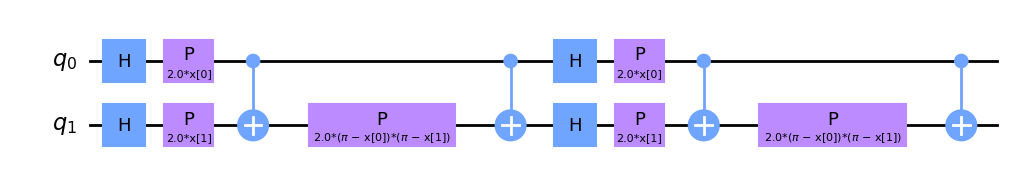

In [47]:
# best_kernel = search.best_params_['kernel'].__self__
# print(f"Best is kernel {kernels.index(best_kernel)} using {best_kernel.feature_map.__class__.__name__} with {best_kernel.feature_map.reps} reps and {best_kernel.feature_map.entanglement} entanglement")
# svc = search.best_estimator_
# best_kernel.feature_map.decompose().draw(output='mpl')

## Train the winning kernel circuit using 10-fold cross validation

In [8]:
best_kernel = kernels[1] # Index from output above
svc = SVC(kernel=best_kernel.evaluate)

results = cross_validate(svc, train_features, train_labels, cv=10, n_jobs=-1, return_estimator=True, return_train_score=True)

KeyboardInterrupt: 

In [52]:
resulting_models = results['estimator']
total_times = results['fit_time'] + results['score_time']
print(f"Time consumed for each SVC: {total_times}, mean: {total_times.mean()}")

Time consumed for each SVC: [6.37669492 6.4197278  6.15953374 6.20961261 6.38523388 6.54740572
 6.36345673 6.47362685 6.3789928  6.3648138 ], mean: 6.3679098844528195


In [54]:
# Calculate accuracy on testing dataset

accuracies = np.array([model.score(test_features, test_labels) for model in resulting_models])

/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/l

### Training evaluation

In [57]:
print(', '.join(map(lambda accuracy: f'{accuracy:.2f}', accuracies)))
print('mean: {:.2f}, std: {:.2f}, mean training time: {:.0f}s'.format(accuracies.mean(), accuracies.std(),
                                                                          np.array(total_times).mean()))

0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 1.00, 0.96, 0.96, 0.96
mean: 0.96, std: 0.01, mean training time: 6s


---
### Classical Implementation

In [58]:
classical_svc = SVC(kernel='rbf')
classical_results = cross_validate(classical_svc, train_features, train_labels, cv=10, n_jobs=-1, return_estimator=True, return_train_score=True)
classical_results

{'fit_time': array([0.00141883, 0.00182605, 0.00184393, 0.00141072, 0.0014112 ,
        0.00212598, 0.00177121, 0.00142193, 0.00319195, 0.00169706]),
 'score_time': array([0.00056577, 0.00056505, 0.00075126, 0.00058532, 0.00058484,
        0.00054717, 0.00069094, 0.00057912, 0.00076604, 0.00072193]),
 'estimator': [SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC()],
 'test_score': array([0.5       , 0.375     , 0.75      , 0.375     , 0.375     ,
        0.71428571, 0.57142857, 0.71428571, 0.42857143, 0.42857143]),
 'train_score': array([0.67164179, 0.65671642, 0.62686567, 0.6119403 , 0.68656716,
        0.60294118, 0.66176471, 0.64705882, 0.72058824, 0.72058824])}

In [37]:
print(f"Classical mean SVC score: {classical_results['test_score'].mean()} with std. deviation {classical_results['test_score'].std()}")

Classical mean SVC score: 0.5232142857142857 with std. deviation 0.14530272761741683


In [59]:
classical_scores = np.array([model.score(test_features, test_labels) for model in classical_results['estimator']])
classical_total_times = results['fit_time'] + results['score_time']
print(', '.join(map(lambda accuracy: f'{accuracy:.2f}', classical_scores)))
print('mean: {:.2f}, std: {:.2f}, mean training time: {:.0f}s'.format(classical_scores.mean(), classical_scores.std(),
                                                                          np.array(classical_total_times).mean()))

0.52, 0.56, 0.56, 0.44, 0.60, 0.44, 0.52, 0.52, 0.60, 0.60
mean: 0.54, std: 0.06, mean training time: 6s


---
### Run on real quantum computer

In [88]:
from qiskit import IBMQ

# Best kernel should already be evaluated and set (in the above code cell)

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='zhaw-1')
backend = least_busy(provider.backends(simulator=False))
print(f"Chosen backend: {backend}")
best_model = resulting_models[np.argmax(accuracies)]
best_model.kernel.__self__.quantum_instance = QuantumInstance(backend, shots=1024)
score = best_model.score(test_features, test_labels)
print(f"Quantum score: {score}")


ibmqfactory.load_account:WARNING:2023-01-09 10:37:43,905: Credentials are already in use. The existing account in the session will be replaced.


KeyboardInterrupt: 